### Metro Interstate Traffic Volume (analysis,visualization, preprocssing,modeling)

The purpose of this project is to analyize and understand the Metro dataset, Also, construct a predictive models using different machine learning algorithms and metrics. 

Our target is "Hourly Interstate 94 Westbound traffic volume" a continues value which means we will use a regression algorithms in our model

__Models used : Random forest, Descision tree, lasso regression with mse, rmse, R2 metric__

In [1]:
import warnings
warnings.filterwarnings('ignore') # hide warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from scipy import stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error


%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10, 8) 

# Part 1: Exploratory data analysis (EDA)

First part of the notebook will be about analyzing and visualizing our data to build an intuition about the dataset we have

In [3]:
X = pd.read_csv('Data\Metro_Interstate_Traffic_Volume.csv')

In [4]:
X.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
print('Dataset shape {}\n'.format(X.shape))

Dataset shape (48204, 9)



In [6]:
dtypes = X.dtypes # The data type of features we have
uniqVal = X.nunique() # number of unique values in each feature in the dataset X
missing = X.isnull().sum() # total null values in each feature in the dataset
min_val = X.min() # minimum value in each feature
max_val = X.max() # maximum value in each feature

# Create a dataframe of the variables above 
df_detail = pd.DataFrame(data = {
            'number of uniques':uniqVal, 'missing':missing, 'min':min_val, 
            'max':max_val, 'dtype':dtypes
})

unique_vals = [X[feature].unique() for feature in df_detail.index] # list of unique values of each feature 
df_detail['unique_values'] = unique_vals 

*__There's no null values in dataset__*

In [7]:
X.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [9]:
#here we extract year, month, day, and time features as integers from date feature
#We also created a 'weekday' feature which is the number of day in the week
# 0->Monday, 1->Tuesday, 2->Wednesday, 3->Thursday, 4->Friday, 5->Saturday, 6->Sunday  

X['date'] = X.date_time.apply(lambda x: x.split()[0]) 
X['year'] = X.date_time.apply(lambda x: x.split()[0].split('-')[0]).astype(int)
X['month'] = X.date_time.apply(lambda x: x.split()[0].split('-')[1]).astype(int)
X['day'] = X.date_time.apply(lambda x: x.split()[0].split('-')[2]).astype(int)
X['weekday'] = X.apply(lambda x: date(x['year'], x['month'], x['day']).weekday(), axis = 1)
X['time'] = X.date_time.apply(lambda x: x.split()[1].split(':')[0]).astype(int)

## 1. Start with analysing 'Traffic volume'

The target value is strongly skewed

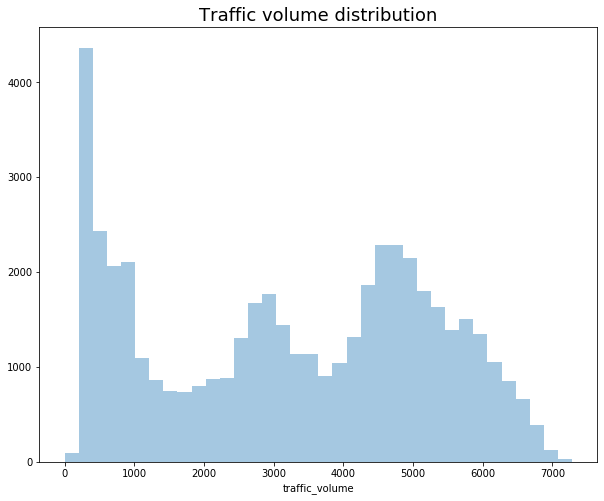

In [10]:
plt.title('Traffic volume distribution', fontsize = 18)
sns.distplot(X['traffic_volume'], kde = False)

We see a weak relation between our target and temp

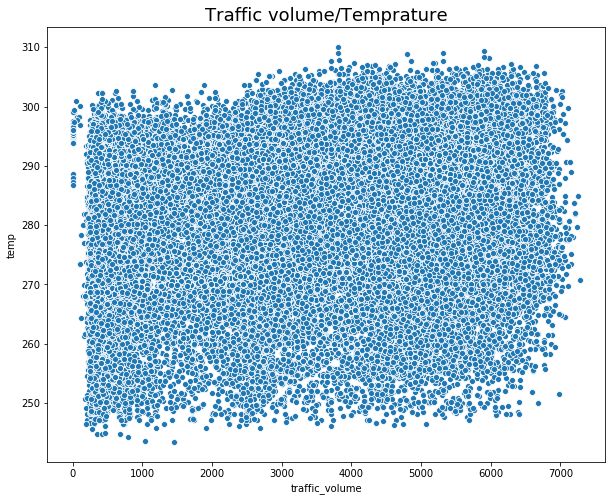

In [52]:
#bivarite analysis
plt.title('Traffic volume/Temprature', fontsize = 18)
sns.scatterplot(x='traffic_volume', y='temp', data = X.loc[X['temp'] > 230, :])

## Bivarite analysis

In [11]:
#Replacing numbers with strings just to make it clear in visualization, it will be fixed when modeling

X['weekday'] = X['weekday'].map({
    0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'
})

X['month'] = X['month'].map({
    1:'Jan', 2:'Feb', 3:'Mar', 4:'April', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})

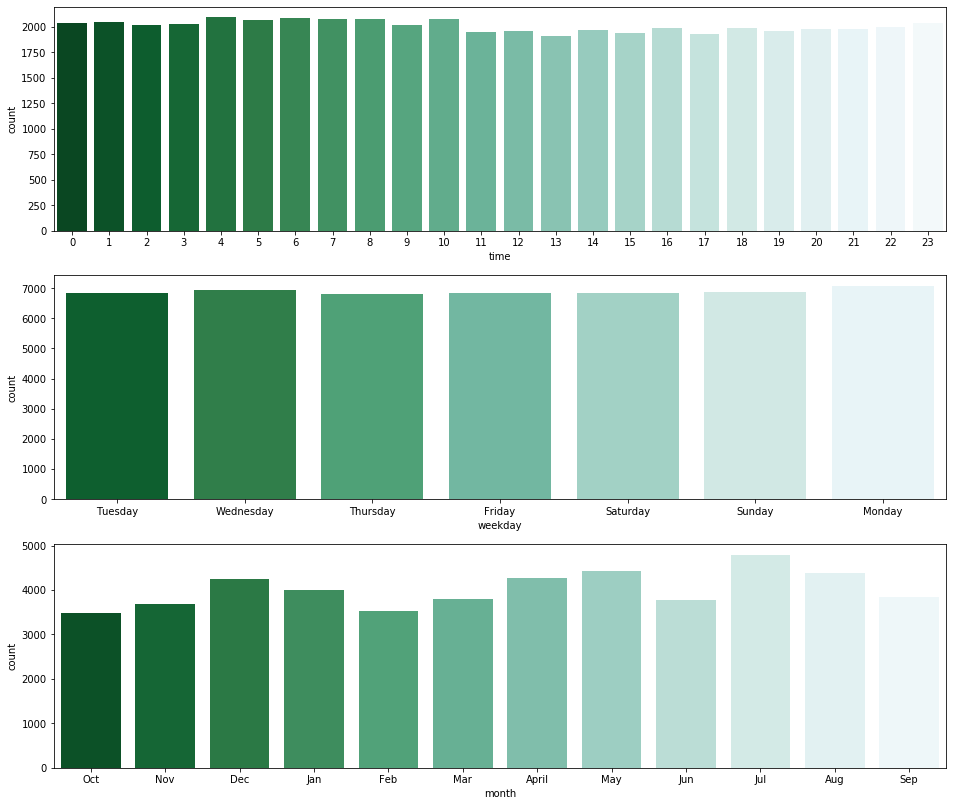

In [12]:
fig, axes = plt.subplots(3)
fig.set_size_inches(16, 14)
sns.countplot(data = X, x = 'time', ax = axes[0], palette = "BuGn_r")
sns.countplot(data = X, x = 'weekday', ax = axes[1], palette = "BuGn_r")
sns.countplot(data = X, x = 'month', ax = axes[2], palette = "BuGn_r")

We can see that time and weekday values in the dataset are evenly distribued.

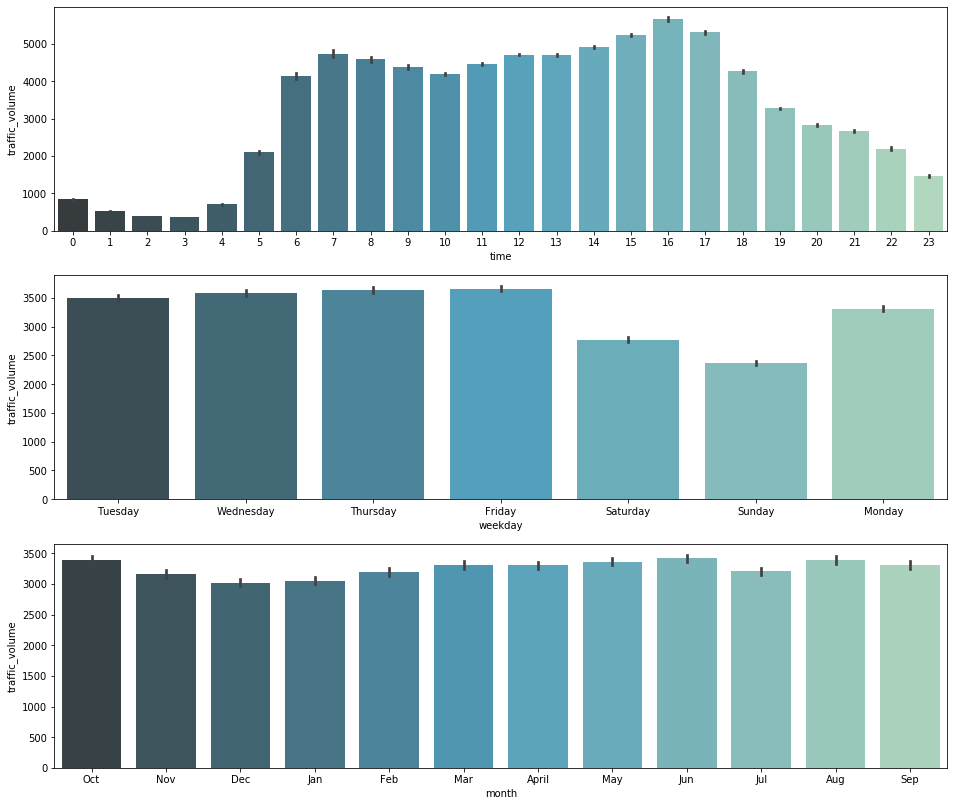

In [13]:
fig, axes = plt.subplots(3)
fig.set_size_inches(16, 14)
sns.barplot(data = X, x = 'time', y = 'traffic_volume', ax = axes[0], palette = 'GnBu_d')
sns.barplot(data = X, x = 'weekday', y = 'traffic_volume', ax = axes[1], palette = 'GnBu_d')
sns.barplot(data = X, x = 'month', y = 'traffic_volume', ax = axes[2], palette = 'GnBu_d')

In 'time' feature we can see that the traffic is high during the day, this suggest that we can create a new feature that split the day into phases (more about that at data preprocessing).

In 'weekday', it seems that the traffic is lower in the weekends, so we should create is_weekend feature
In 'traffic_volume', the traffic is slightly lower in winter months (Dec, Jan). 

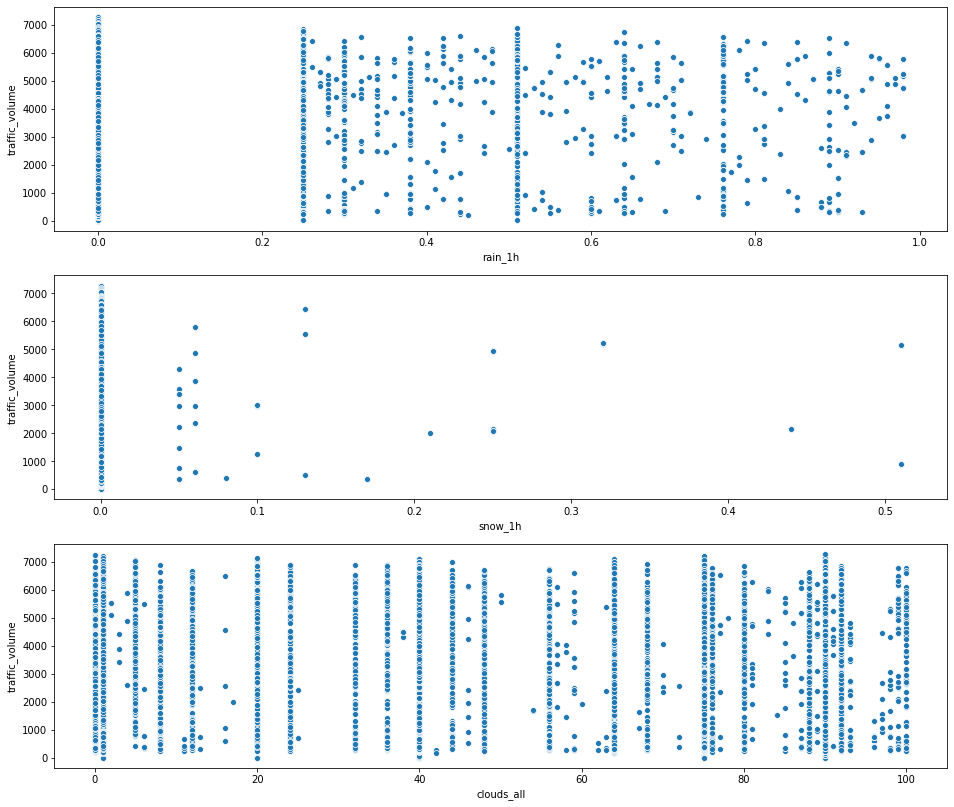

In [14]:
fig, axes = plt.subplots(3)
fig.set_size_inches(16, 14)
sns.scatterplot(x = X['rain_1h'].loc[X['rain_1h']<1], y = X['traffic_volume'], ax = axes[0])
sns.scatterplot(x = X['snow_1h'], y = X['traffic_volume'], ax = axes[1])
sns.scatterplot(x = X['clouds_all'], y = X['traffic_volume'], ax = axes[2])

in 'rain_1h', the gap shows that there's a missing of information in the dataset, the traffic is intense when it's 0

in 'snow_1h', it's obvious that the traffic is way fewer when snow > 0

in 'clouds_all', there's no obivous relation between clouds and traffic volume

## Univariate analysis

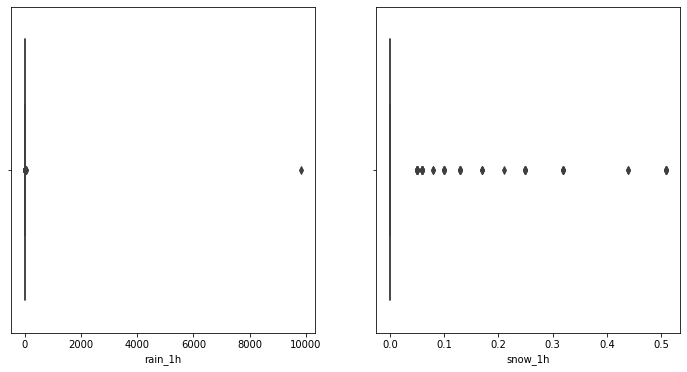

In [15]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12, 6)
sns.boxplot(data = X, x = 'rain_1h', ax = axes[0])
sns.boxplot(data = X, x = 'snow_1h', ax = axes[1])

This values is way too large and unlogical so it's clearly and invalid entry (outlier) and should be removed 

In [16]:
#Printing the lower values of rain_1h and high values to see the outlier and make comparison 

rain_1h_sorted = X['rain_1h'].sort_values(ascending = True)
low_range = rain_1h_sorted[:3]
high_range = rain_1h_sorted[-3:]
print('low range of the distribution:')
print(low_range)
print('\nhigh range of the distribution:')
print(high_range)

low range of the distribution:
0        0.0
31796    0.0
31797    0.0
Name: rain_1h, dtype: float64

high range of the distribution:
7179       44.45
8247       55.63
24872    9831.30
Name: rain_1h, dtype: float64


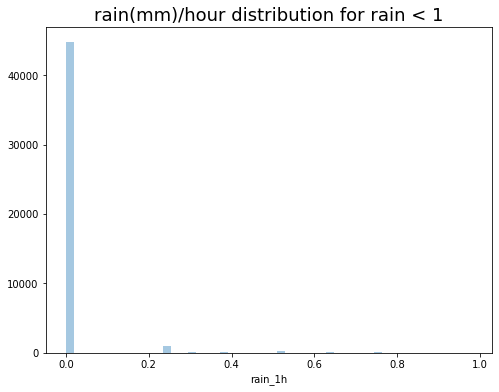

In [17]:
plt.figure(figsize=(8,6))
plt.title('rain(mm)/hour distribution for rain < 1', fontsize = 18)
sns.distplot(X['rain_1h'].loc[X['rain_1h']<1], kde = False)

In [18]:
#convert temprature from kelvin to celsius to make it more intuitive
X['temp'] = X['temp']-273.15

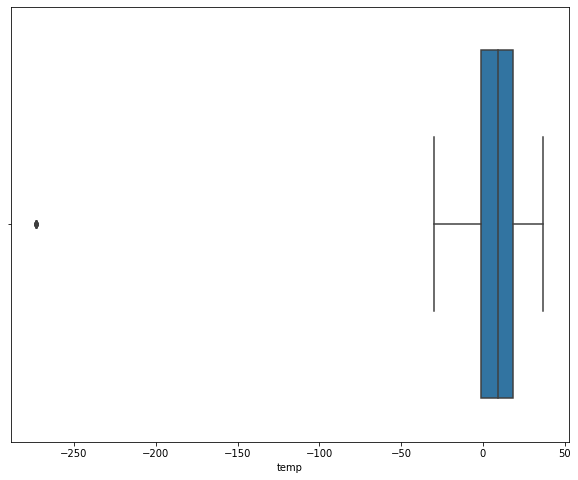

In [19]:
sns.boxplot('temp', data = X)

-273.15c is not a logical temprature, so it's invalid entries (more than 1 entry with that value)

In [20]:
temp_sorted = X['temp'].sort_values(ascending = True)
low_range = temp_sorted[:3]
high_range = temp_sorted[-3:]
print('low range of the distribution:')
print(low_range)
print('\nhigh range of the distribution:')
print(high_range)

low range of the distribution:
11946   -273.15
11947   -273.15
11948   -273.15
Name: temp, dtype: float64

high range of the distribution:
45425    35.93
45424    36.14
44457    36.92
Name: temp, dtype: float64


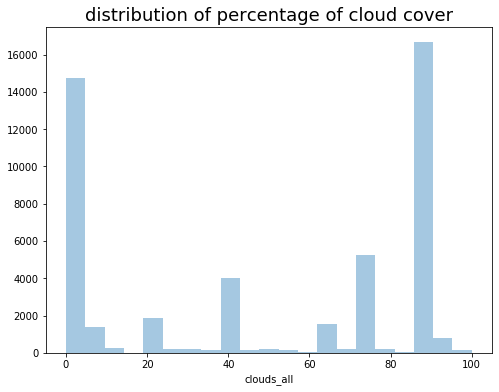

In [21]:
plt.figure(figsize=(8,6))
plt.title('distribution of percentage of cloud cover', fontsize = 18)
sns.distplot(X['clouds_all'], kde = False)

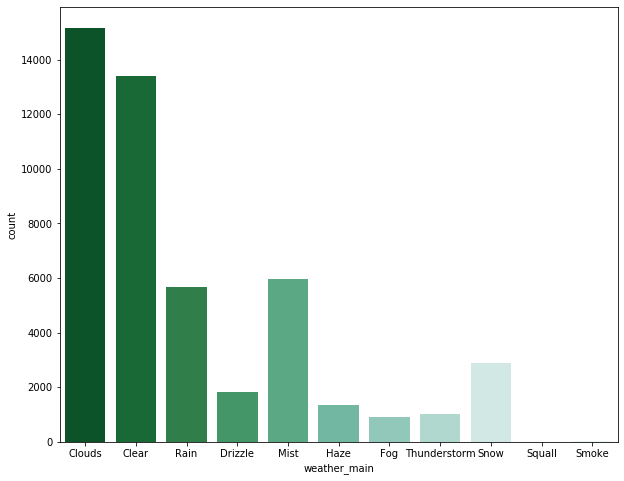

In [22]:
sns.countplot(x='weather_main', data=X, palette = "BuGn_r")

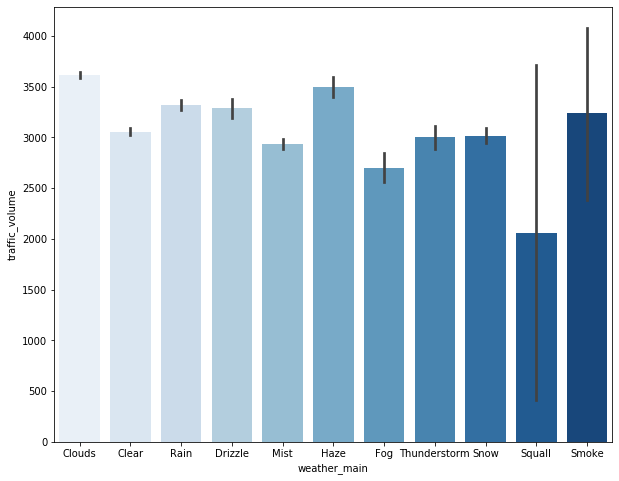

In [23]:
sns.barplot(data = X, x = 'weather_main', y = 'traffic_volume', palette = 'Blues')

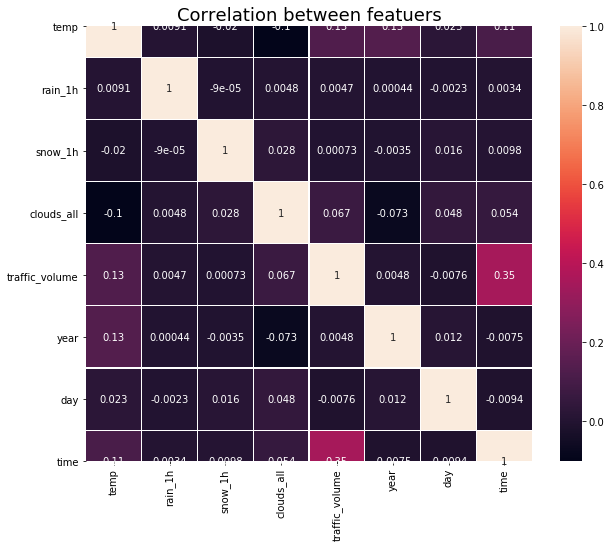

In [24]:
X_cor = X.corr()
plt.title('Correlation between featuers', fontsize=18)
sns.heatmap(data = X_cor, annot=True, linewidths=0.2)

Heatmap shows that the relationship between values is very weak

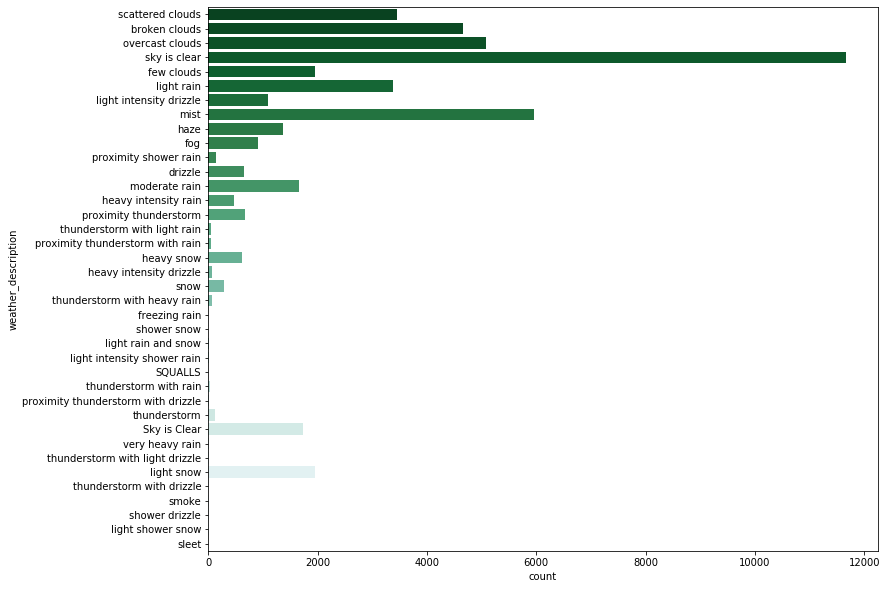

In [25]:
plt.figure(figsize=(12,10))
sns.countplot(y='weather_description', data=X, palette = "BuGn_r")

## Data preprocessing

In [26]:
X = pd.read_csv('Data\Metro_Interstate_Traffic_Volume.csv')

X['date'] = X.date_time.apply(lambda x: x.split()[0])
X['year'] = X.date_time.apply(lambda x: x.split()[0].split('-')[0]).astype(int)
X['month'] = X.date_time.apply(lambda x: x.split()[0].split('-')[1]).astype(int)
X['day'] = X.date_time.apply(lambda x: x.split()[0].split('-')[2]).astype(int)
# 0->Monday, 1->Tuesday, 2->Wednesday, 3->Thursday, 4->Friday, 5->Saturday, 6->Sunday
X['weekday'] = X.apply(lambda x: date(x['year'], x['month'], x['day']).weekday(), axis = 1)
X['time'] = X.date_time.apply(lambda x: x.split()[1].split(':')[0]).astype(int)

#Mapping holiday feature, 1 if holiday otherwise 0
X.loc[X['holiday'] != 'None', 'holiday'] = 1
X.loc[X['holiday'] == 'None', 'holiday'] = 0

#convert from kelvin to celisus
X['temp'] = X['temp']-273.15

#### Getting rid of outliers in *temp* and *rain_1h*

In [27]:
#value to drop in temp -> -273.15
#value to drop in rain_1h -> 9831.30
X = X.loc[X.temp!=-273.15]
X = X.loc[X.rain_1h != 9831.30]

__We will add the following new features__

*__season__*, as the name suggest it will hold the season of the current date with values -> summer, autumn, winte, summer

*__day_phase__*, divide the day into phases: -
    * 20-4 night
    * 4-6 dawn
    * 6-10 Morning
    * 10-16 DayTime
    * 16-18 Evening
    * 18-20 Dusk
    

*__is_weekend__*, 1 if the current day is a weekend otherwise 0

*__is_snow__*, 1 if there's snow otherwise 0

*__is_rain__*, 1 if there's a rain otherwise 0

*__mist__*, *__haze__*, *__fog__*, *__heavy_snow__*, 1 if there's a mist/haze/fog/heavy_snow (from weather description) otherwise 0

In [28]:
bins = (-1,4,6,10,16,18,20,24)
categories = ['N', 'Dawn', 'Morning', 'DayTime', 'Evening', 'Dusk', 'Night']

X['day_phase'] = pd.cut(X['time'], bins, labels=categories, right = True)
X.loc[X['day_phase'] == 'N', 'day_phase'] = 'Night'

In [29]:
bins = (0,2,5,8,11,12)
categories = ['Winter', 'Spring', 'Summer', 'Autumn', 'W']

X['season'] = pd.cut(X['month'], bins, labels=categories, right = True)
X.loc[X['season'] == 'W', 'season'] = 'Winter'

In [30]:
X['is_weekend'] = X['weekday'].map(lambda x: 1 if(x in [6, 5]) else 0)
X['is_snow'] = X['snow_1h'].map(lambda x: 1 if(x > 0) else 0)
X['is_rain'] = X['rain_1h'].map(lambda x: 1 if(x > 0) else 0)


new_features = ['haze', 'mist', 'fog', 'heavy snow']
for feature in new_features:
    feat_name = '_'.join(feature.split(' ')) #to construct name for the current feature
    X[feat_name] = 0
    X.loc[X['weather_description'] == feature, feat_name] = 1

### Decoding

In [31]:
#date, date_time, weather_description will be drop as the are string values and we already extracted the desired data from them
X.drop(['date', 'date_time', 'weather_description'], inplace = True, axis = 1)

In [32]:
str_value = ['weather_main', 'day_phase', 'season']

for val in str_value:
    encoder = LabelEncoder()
    X[val] = encoder.fit_transform(X[val])


### Modeling

We will begin with tree-based algorithms as they don't require scaling and normalizing for the values

### 1: Desision Tree

In [33]:
y = X['traffic_volume']
X = X.drop(['traffic_volume'], axis = 1)

#Splitting our dataset make the test dataset 30% of the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [34]:
# Define error measure for official scoring : MSE, MSE, R2, MAR
scorer = make_scorer(mean_squared_error, greater_is_better = False)
r2_scorer = make_scorer(r2_score, greater_is_better = True)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better = False)

def rmse_mse_cv_test(model, x, y):
    mse = -cross_val_score(model, x, y, scoring = scorer, cv = 10)
    rmse = np.sqrt(mse)
    
    return(rmse, mse)

def r2_cv_test(model, x, y):
    r2_test = cross_val_score(model, x, y, scoring = r2_scorer, cv = 10)

    return r2_test

def mae_cv_test(model, x, y):
    mae = -cross_val_score(model, x, y, scoring = mae_scorer, cv = 10)
    
    return mae

Optimal depth:  11


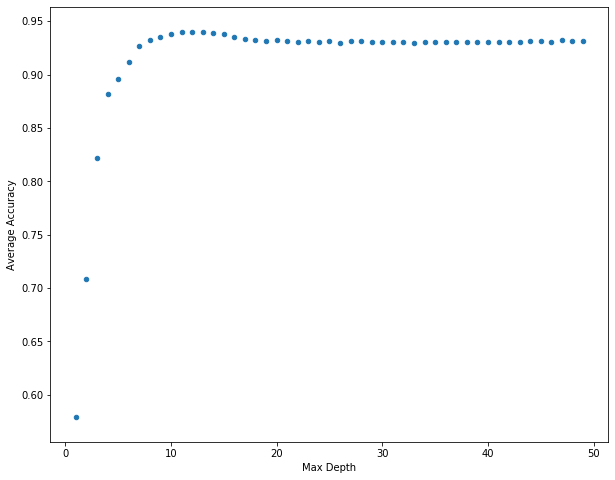

In [35]:
#hyperparameter tuning 
#Finding the optimal depth of the descision tree with KFold 

cv = KFold(n_splits=10) # Desired number of Cross Validation folds
accuracies = list()
max_attributes = 50
depth_range = range(1, max_attributes)

# Testing max_depths from 1 to max attributes
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeRegressor(max_depth = depth)
    for train_fold, valid_fold in cv.split(X_train):
        
        train_x = X_train.iloc[train_fold]        # Extract train data with cv indices
        train_y = y_train.iloc[train_fold]        # Extract train data with cv indices

        valid_x = X_train.iloc[valid_fold]        # Extract valid data with cv indices
        valid_y = y_train.iloc[valid_fold]        # Extract valid data with cv indices
        
        model = tree_model.fit(X = train_x, y = train_y ) # We fit the model with the fold train data
        valid_acc = model.score(X = valid_x, y = valid_y)# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
df = df.sort_values(by='Average Accuracy', ascending = False)
df.plot(kind = 'scatter', y = 'Average Accuracy', x = 'Max Depth', figsize = (10, 8))
print('Optimal depth: ', df.iloc[0,0])

RMSE SCORE:  523.2014034874546
MSE SCORE:  274291.18324426597
R2 SCORE:  0.9301375936988988
MAE SCORE:  296.168046869504


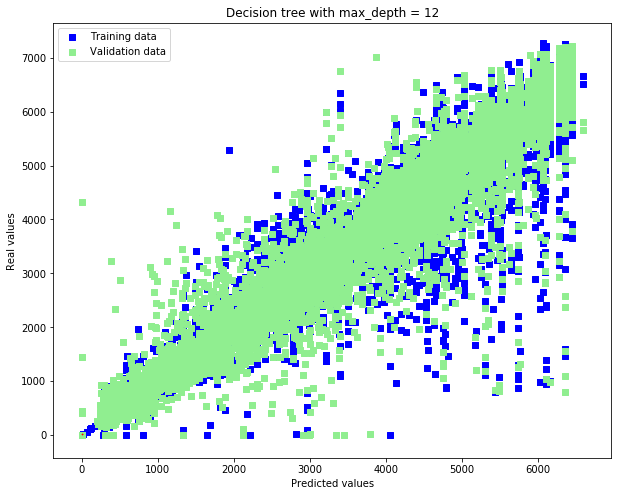

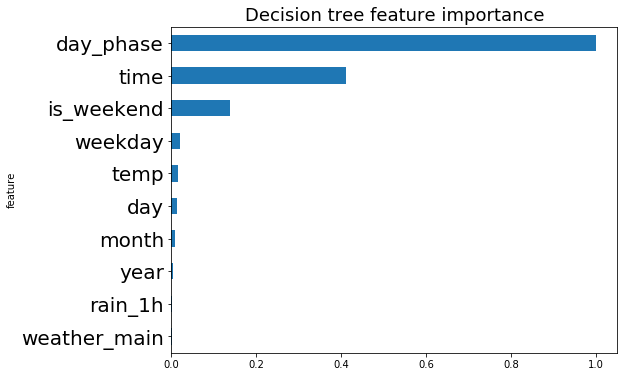

In [36]:
# Fitting and evaluting the result on the test set
# Create Decision Tree with max_depth = 12 (optimal depth)
decision_tree = DecisionTreeRegressor(max_depth = 12)
decision_tree.fit(X_train, y_train)

# Predicting results for test dataset
rmse_test, mse_test = rmse_mse_cv_test(decision_tree, X_test, y_test)
r2_s = r2_cv_test(decision_tree, X_test, y_test)
mae_score = mae_cv_test(decision_tree, X_test, y_test)

print("RMSE SCORE: ", rmse_test.mean())
print("MSE SCORE: ", mse_test.mean())
print("R2 SCORE: ", r2_s.mean())
print("MAE SCORE: ", mae_score.mean())


y_train_las = decision_tree.predict(X_train)
y_test_las = decision_tree.predict(X_test)


# Plot predictions
plt.figure(figsize=(10, 8))
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Decision tree with max_depth = 12")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

df_ = pd.DataFrame(X_train.columns, columns = ['feature'])
df_['fscore'] = decision_tree.feature_importances_[:, ]

# Plot the relative importance of the top 10 features
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)
df_.plot(kind='barh', x='feature', y='fscore', legend=False,figsize = (8,6))
plt.title('Decision tree feature importance', fontsize = 18)
plt.yticks(fontsize=20)
plt.show()

### 2: Random Forest 

In [37]:
parameters = {
        'n_estimators': [100, 150, 200, 300],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [5, 12, 15],
        'bootstrap': [True, False]
}

rf = RandomForestRegressor()

random_search = RandomizedSearchCV(rf, parameters, n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [38]:
print(random_search.best_params_)

{'n_estimators': 150, 'max_features': 'auto', 'max_depth': 15, 'bootstrap': True}


RMSE SCORE  439.1954175340802
MSE SCORE:  193481.73184060634
R2 SCORE:  0.9513069061739673
MAE SCORE:  248.49876989809923


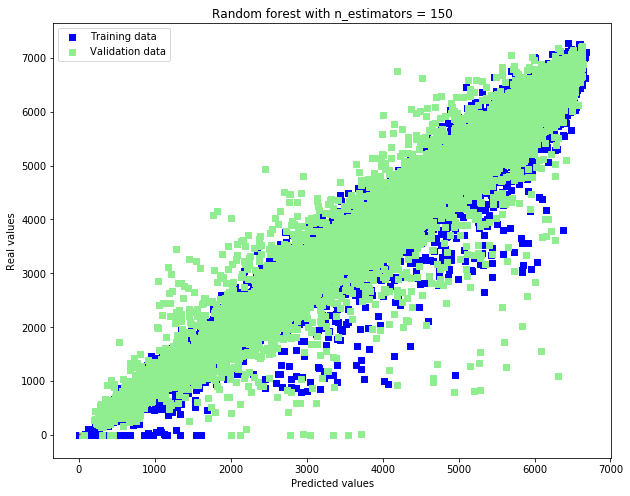

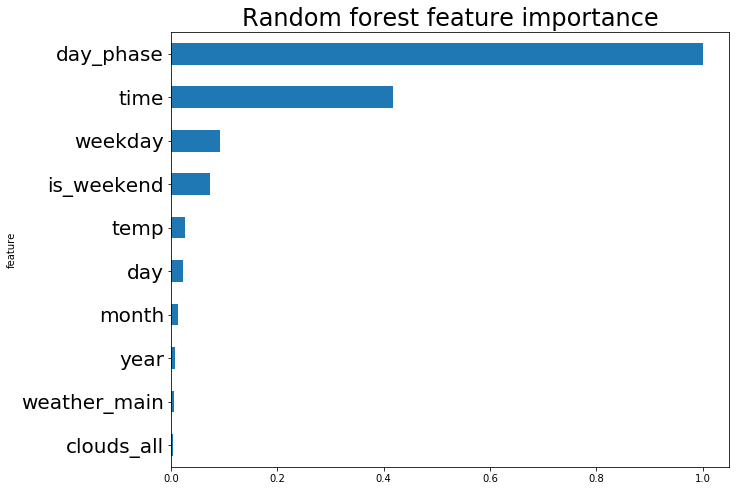

In [41]:
rf=RandomForestRegressor(max_features='auto', n_estimators=150, max_depth=15, criterion='mse', bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Predicting results for test dataset
rmse_test, mse_test = rmse_mse_cv_test(rf, X_test, y_test)
r2_s = r2_cv_test(rf, X_test, y_test)
mae_score = mae_cv_test(rf, X_test, y_test)

print("RMSE SCORE ", rmse_test.mean())
print("MSE SCORE: ", mse_test.mean())
print("R2 SCORE: ", r2_s.mean())
print("MAE SCORE: ", mae_score.mean())

y_train_las = rf.predict(X_train)
y_test_las = rf.predict(X_test)

# Plot predictions
plt.figure(figsize=(10, 8))
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random forest with n_estimators = 150")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

df_ = pd.DataFrame(X_train.columns, columns = ['feature'])
df_['fscore'] = rf.feature_importances_[:, ]

# Plot the relative importance of the top 10 features
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)
df_.plot(kind='barh', x='feature', y='fscore', legend=False,figsize = (10,8))
plt.title('Random forest feature importance', fontsize = 24)
plt.yticks(fontsize=20)
plt.show()

### 3:Linear Regression with Lasso regularization (L1 penalty)

We have to perfom data scale on the data as linear algorithm doesn't deal with them like tree-based algorithms

In [42]:
dummy_values = ['snow_1h','weekday', 'time', 'month', 'year','weather_main', 'day_phase', 'season']
X[dummy_values] = pd.get_dummies(X[dummy_values]) 

In [43]:
scale_vals = ['temp','clouds_all']

scaler = StandardScaler()
X[scale_vals] = scaler.fit_transform(X[scale_vals])

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05

RMSE SCORE:  1496.762920184341
MSE SCORE:  2242181.6852110922
R2 SCORE:  0.43616075546665883
MAE SCORE:  1201.1310715941931


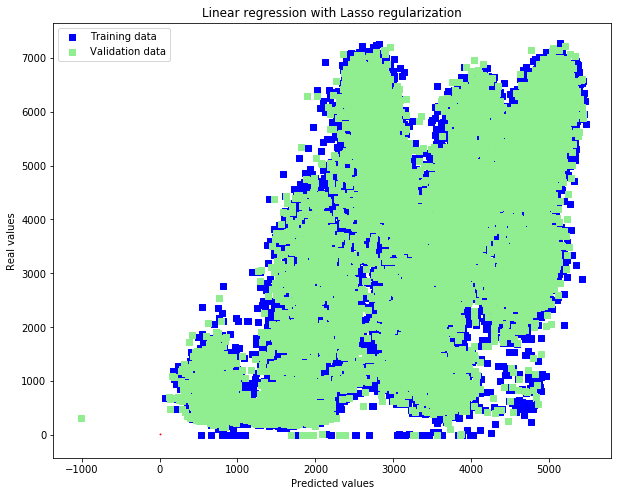

Lasso picked 20 features and eliminated the other 0 features


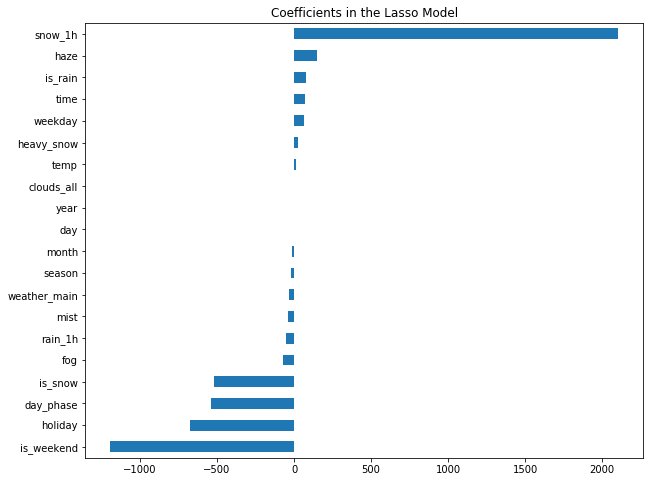

In [44]:
# 1* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

rmse_test, mse_test = rmse_mse_cv_test(lasso,  X_test, y_test)
r2_s = r2_cv_test(lasso, X_test, y_test)
mae_score = mae_cv_test(lasso, X_test, y_test)

print("\nRMSE SCORE: ", rmse_test.mean())
print("MSE SCORE: ", mse_test.mean())
print("R2 SCORE: ", r2_s.mean())
print("MAE SCORE: ", mae_score.mean())


y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()